**1. Загрузка**

In [17]:
import csv
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import urllib.request
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_train = pd.read_csv('df_train.csv', sep=';')
df_test = pd.read_csv('df_test.csv', sep=';')

**2. Предварительный анализ**

Основные характеристики тренировочного датасета и проверка наличия missing values:

In [3]:
df_train.shape

(7033, 3)

In [4]:
df_train.head(3)

,Id,Data,Target
0,0,"4814,4814,6010,6011,4814,6011,6011,4814,6011,6...","4814,4814,4814,4814,5411,4814,4814,4814,4814,4814"
1,1,"6011,6011,6011,6011,6011,6011,6011,4814,4814,4...","4814,6011,4814,6011,4814,4814,6011,4814,6011,4814"
2,2,"8021,6011,6011,6010,4829,4814,6011,6011,6011,6...","6011,6011,6010,4829,4829,6010,6011,6011,4814,6011"


In [5]:
sum(df_train['Data'].isnull()), sum(df_train['Target'].isnull())

(0, 0)

Характеристики транзакций в измерении Data:

In [6]:
sequences = [row.split(',') for row in df_train['Data']]
minimum = len(min(sequences, key=len))
maximum = len(max(sequences, key=len))
average = sum([len(sequence) for sequence in sequences])/len(sequences)
print('Минимальная длина строки: ' + str(minimum))
print('Максимальная длина строки: ' + str(maximum))
print('Средняя длина строки: ' + str(round(average)))

Минимальная длина строки: 40
Максимальная длина строки: 21101
Средняя длина строки: 473


Посмотрим на распределение MCC кодов по всему датасету.
Для начала создадим функцию-"переводчик" MCC кодов с сайта mcc-code.ru (указан в Overview к задаче). Это действие необязательно, но помогает глубже разобраться в данных:

In [7]:
def get_definition_mcc(mcc):
	'''Найти описание mcc-кода'''
	url = 'https://www.mcc-codes.ru/code/' + str(mcc)
	try:
		with urllib.request.urlopen(url) as page:
			html = page.read().decode(page.headers.get_content_charset())
			text_to_find="MCC "+mcc+": "
			start_index = html.find(text_to_find)
			end_index = html.find("</title>")
			return html[(start_index+len(text_to_find)):end_index]
	except:
		return "MCC не найдено или ошибка"


Далее выведем характеристики топ-N MCC кодов (например, для топ-10):

In [8]:
flatten = [item for row in sequences for item in row]
codes = Counter(flatten)

N=10
top_codes=dict(sorted(codes.items(), key=lambda x:x[1], reverse=True)[:N])
codes_df = pd.DataFrame(top_codes.items(), columns=['MCC','Всего'])
codes_df['на клиента']=round(codes_df['Всего']/len(df_train['Data']))

codes_df['Описание']=list(map(get_definition_mcc, top_codes))

print(codes_df)

    MCC   Всего  на клиента                                           Описание
0  6011  700677       100.0  Финансовые учреждения – снятие наличных автома...
1  6010  490602        70.0    Финансовые учреждения – выдача наличных в кассе
2  4814  473396        67.0                        Телекоммуникационные услуги
3  5411  472408        67.0                  Бакалейные магазины, супермаркеты
4  4829  307388        44.0                                  Денежные переводы
5  5499  164719        23.0  Различные продовольственные магазины - нигде б...
6  5541   68224        10.0  Заправочные станции (с вспомогательными услуга...
7  5912   65071         9.0                                             Аптеки
8  5331   61833         9.0                             Универсальные магазины
9  5812   52029         7.0             Места общественного питания, рестораны



В топе, как и ожидалось, коды с ежедневными операциями. При этом они распределены неравномерно:  

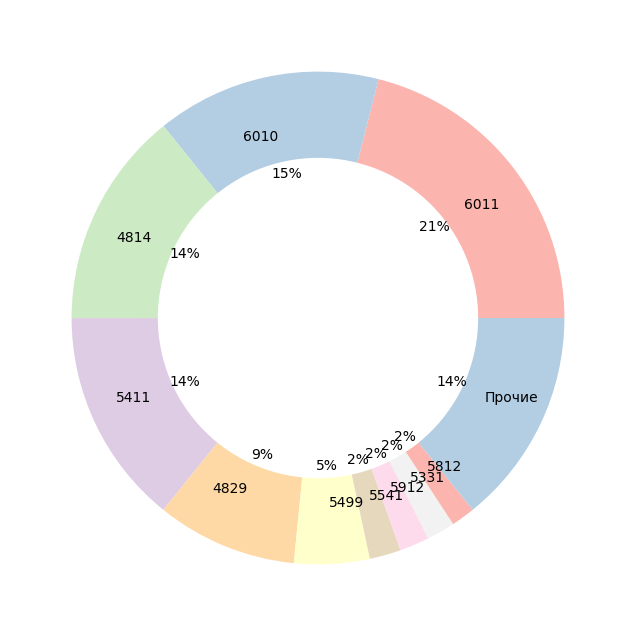

In [9]:
labels = list(codes_df['MCC'])
labels.append('Прочие')
share = list(codes_df['Всего'])
other=len(flatten)-sum(codes_df['Всего'])
share.append(other)

plt.figure(figsize=(8,8))
hole=plt.Circle((0, 0), 0.65, facecolor='white')
plt.pie(
    share, 
    labels=labels,
    labeldistance=0.75,
    autopct='%1.f%%',
    colors=plt.cm.Pastel1.colors)
plt.gcf().gca().add_artist(hole);

Постараемся учесть эти особенности в прогнозировании.

***3. Прогнозирование на данных тренировочного датасета***

Напишем функцию прогнозирования будущих транзакций. При этом прогнозирование будет выполняться в два этапа:

1) Так как коды распределены неравномерно - выделим нужное количество будущих транзакций в пропорции к тому, как часто они встречаются в Data. Учтем возможность смещать чувствительность алгоритма к более новым или старым транзакциям в последовательности датасета

2) Распределим равномерно полученные транзации в предсказанной последовательности

In [10]:
def predict_mcc_codes(dataframe,x=0,N=10):
	'''Предсказание будущих транзакций

	Параметры:
	dataframe - объект DataFrame (тренировочный или тестовый)

	x - смещение чувствительности транзакции относительно положения в датасете Data:
		0 - без смещения (по умолчанию); 
		<0 - смещение в сторону более старых транзакций;
		>0 - смещение в сторону более новых транзакций

	N - количество требуемых предсказаний (по умолчанию 10)'''

	dataframe['Predicted']=''
	for line in range(0,len(dataframe)):
		seq = dataframe['Data'][line].split(',')

		frequency, prediction_db={},{}
		length_with_x=0

		#Этап 1: распределяем N предсказаний пропорционально частоте mcc кодов каждого пользователя
		
		"""Подготовка словаря с частотой mcc кодов пользователя с учетом заданного смещения"""
		for i in range(0,len(seq)):
			mcc=seq[i]
			add_x=1+i*(x/(len(seq)))
			frequency[mcc]=add_x if (mcc not in frequency) else (frequency[mcc]+add_x)
			length_with_x+=add_x
		
		"""Сохраняем N предсказанных транзакций с учетом частоты mcc кодов и заданного смещения 
		Так как из-за округления транзакций может оказаться меньше N, то остаток
		заполняем самым распространенным кодом."""
		prediction_db={mcc:(round(freq/length_with_x*N)) for (mcc,freq) in frequency.items()}
		top_mcc=max(set(seq), key=seq.count)
		while sum(prediction_db.values())<N:
			prediction_db[top_mcc]+=1
            
		"""Убираем пустые элементы и сортируем словарь по убыванию числа кодов"""
		prediction_db=dict((mcc,freq) for mcc,freq in prediction_db.items() if freq)
		prediction_db=dict(sorted(prediction_db.items(), key=lambda x:x[1], reverse=True))

		#Этап 2: полученные будущие транзакции равномерно распределяем в предсказании

		"""Расчет коэффициента равномерного распределения"""
		k=len(prediction_db)/N

		"""Распределяем коды из полученного на первом этапе словаря"""
		prediction=[]
		while sum(prediction_db.values())!=0:
			for mcc, n in prediction_db.items():
				times=1 if (0<n*k<1) else round(n*k)
				prediction.extend([mcc]*times)
				prediction_db[mcc]-=times

		dataframe['Predicted'][line]=','.join(prediction)

Функция расчета метрики совпадения:

In [11]:
def apk(actual, predicted, k=10):
    if not actual:
        return 0.0

    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

По умолчанию написанная функция дает следующий результат:

In [12]:
predict_mcc_codes(dataframe=df_train)
mapk(df_train['Target'], df_train['Predicted'])

0.38751058501982716

Как упоминалось выше, функция позволяет смещать расчет частоты вхождения mcc-кодов в последовательности клиента. Можно выдвинуть три гипотезы:
1) Чем дольше транзакция не встречалась, тем вероятнее, что она возникнет в предсказанной последовательности (смещение к более старым транзакциям в последовательности, параметр **x<0**)

2) Транзакции встречаются равномерно (без смещения, параметр **x=0**)

3) Последние транзакции пользователя лучше отражают будущую последовательность (смещение к более новым транзакциям в последовательности, параметр **x>0**) 

Рассчитаем метрики относительно гипотез:

In [13]:
results={}
for x in range(-100,100,5):
	predict_mcc_codes(dataframe=df_train,x=x)
	results[x]=mapk(df_train['Target'], df_train['Predicted'])

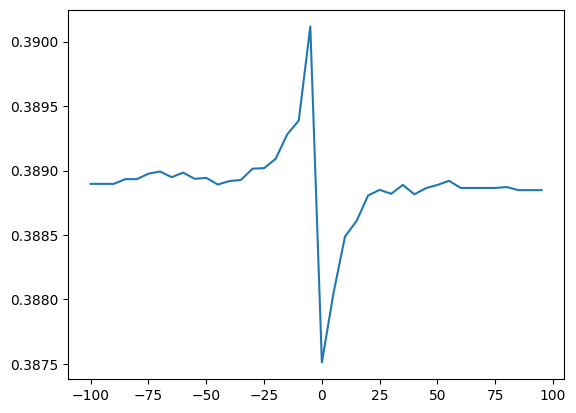

In [14]:
plt.plot(
    results.keys(), 
    results.values());

Топ результатов:

In [15]:
sorted_results = dict(sorted(results.items(), key=lambda x:x[1], reverse=True))
list(sorted_results.items())[:3]

[(-5, 0.3901175636850313),
 (-10, 0.38938780104676585),
 (-15, 0.38927958671027063)]

Смещение относительно **х=0** улучшает результат, причем отрицательные значения коэффициента **х** - в большей степени.
Таким образом, более верной оказывается гипотеза 1 - покупки в точках с mcc-кодами, которые чуть дольше обычного не встречались в последовательности, с большей вероятностью возникнут в следующих покупках. Однако сильное смещение в ту или иную сторону ухудшает прогноз и выводит показатель на "плато" в ≈0,389.

***4. Прогнозирование на тестовом датасете и сохранение данных***

Сохраним несколько сценариев с учетом топ результатов по коэффициенту смещения **х**:

In [16]:
for x in [-5,-10,-15]:
	predict_mcc_codes(dataframe=df_test,x=x)

	submission=df_test[['Id','Predicted']]
	submission['Predicted']=submission.Predicted.astype(str).str.replace(',',' ')
	submission['Predicted']='['+submission['Predicted']+']'
	filename = 'submission Izhevskiy X ' + str(x) + '.csv'
	submission.to_csv(filename, index=False,quoting=csv.QUOTE_NONE)